# Invasive Species Monitoring and the power of transfer learning

The goal of this notebook is to classify images of invasive plant species.

The data for this competition can be found [here](https://www.kaggle.com/c/invasive-species-monitoring).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. 
To get the data: <br>
`kaggle competitions download -c invasive-species-monitoring -p .` <br>

In [3]:
PATH = Path("/data2/yinterian/invasive-species-monitoring/")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/invasive-species-monitoring/train_labels.csv'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train.7z'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/test.7z'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/model.pth'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/__MACOSX'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/mode_tmp.pth'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/test'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train_303_227'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/sample_submission.csv.zip'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/models'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train_labels.csv.zip')]

In [4]:
list((PATH/"train").iterdir())[:10] 

[PosixPath('/data2/yinterian/invasive-species-monitoring/train/2249.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/92.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/302.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/2031.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/1903.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/1605.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/352.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/654.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/1261.jpg'),
 PosixPath('/data2/yinterian/invasive-species-monitoring/train/388.jpg')]

In [5]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

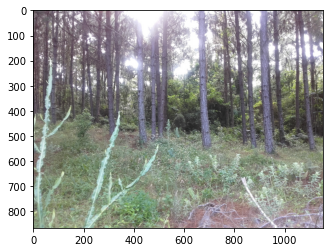

In [6]:
path = PATH/"train/2249.jpg"
im = read_image(path)
plt.imshow(im)

In [7]:
im = cv2.imread(str(path))
im.shape

(866, 1154, 3)

In [8]:
# let's look at the typical size of these images
path = PATH/"train"
files = list(path.iterdir())[:200]
dims = [read_image(str(p)).shape for p in files]

In [9]:
np.unique(dims)

array([   3,  866, 1154])

Amazing! all images have the same size.

In [10]:
866/3.8, 1154/3.8

(227.89473684210526, 303.6842105263158)

## Data augmentation
Data augmentation is the most important way to avoid overfitting for image classification tasks.

In [11]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop

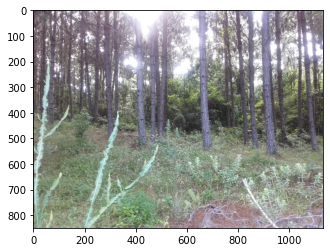

In [12]:
path = PATH/"train/2249.jpg"
im = read_image(path)
im = center_crop(im)
plt.imshow(im, cmap='gray')

### Resize, horizontal and vertical translations

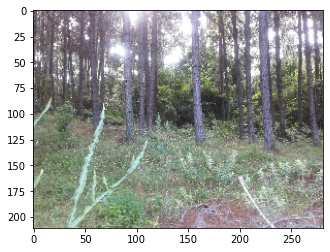

In [13]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
im = cv2.resize(im, (303, 227))
im2 = random_crop(im)
plt.imshow(im2, cmap='gray')

### Random Rotation (-10, 10) 

-6.167470130171255


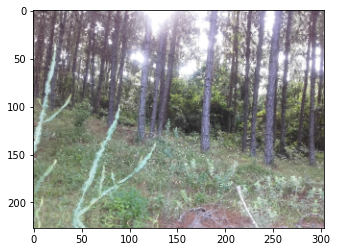

In [14]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

### Horizontal Flip

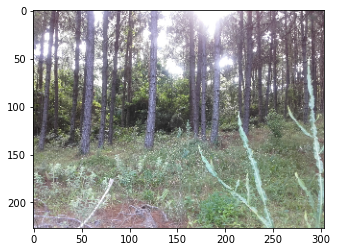

In [15]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

## Split train and validation

In [16]:
labels = pd.read_csv(PATH/"train_labels.csv")
labels.head()

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [17]:
# how many classes
np.unique(labels.invasive.values)

array([0, 1])

In [18]:
# ration of 1 / total
labels.invasive.values.sum()/len(labels)

0.6309368191721133

In [19]:
np.random.seed(3)
mask = np.random.random(len(labels)) < 0.8
train_labels = labels[mask].copy()
valid_labels = labels[~mask].copy()

In [20]:
len(labels), len(train_labels), len(valid_labels) 

(2295, 1860, 435)

## Resizing data
Resizing the data before you do training will save you lots of time!

In [21]:
def resize_crop_image(path, sz=(303, 227)):
    im = read_image(path)
    im = center_crop(im)
    return cv2.resize(im, sz)

In [22]:
def resize_all_images(resize_path, org_path):
    files = [x for x in list(org_path.iterdir()) if x.suffix == ".jpg"]
    for f in files:
        f_name = f.parts[-1]    
        new_path = resize_path/f_name
            
        im = resize_crop_image(f)
        cv2.imwrite(str(new_path), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [23]:
# just run the first time
#resize_all_images(PATH/"train_303_227", PATH/"train")

## Dataset

In [24]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [55]:
class InvasiveDataset(Dataset):
    def __init__(self, files_path, labels, transform=False):
        self.num_files = len(labels)
        self.files_path = files_path
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, index):
        row = self.labels.iloc[index,:]
        y = row["invasive"]
        file_name = str(row["name"]) + ".jpg"
        path = self.files_path/file_name
        x = read_image(path)/255
        if self.transform:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            x = random_crop(x)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
        else:
            x = center_crop(x)
        x = normalize(x)
        return np.rollaxis(x, 2), y[None]

In [56]:
train_ds = InvasiveDataset(PATH/"train_303_227", labels=train_labels, transform=True)
valid_ds = InvasiveDataset(PATH/"train_303_227", labels=valid_labels)

In [57]:
len(train_ds), len(valid_ds)

(1860, 435)

In [60]:
x, y = train_ds[0]
x.shape, y

((3, 211, 281), array([0]))

In [61]:
x, y = valid_ds[0]
x.shape,y

((3, 211, 281), array([1]))

In [30]:
len(train_ds)

1860

In [31]:
# run this multiple times to get different images
x, y = train_ds[0]
#plt.imshow(np.rollaxis(x1, 2), cmap='gray')

In [32]:
x.shape,y

((3, 211, 281), array([0]))

## Toy model

In [33]:
class ToyNet(nn.Module):
    def __init__(self):
        super(ToyNet, self).__init__()
        self.conv1= nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(128, 1) 
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [34]:
batch_size = 5
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [35]:
x, y = next(iter(train_dl))

In [36]:
x.shape

torch.Size([5, 3, 211, 281])

In [37]:
model = ToyNet()
y_hat = model(x.float())

In [38]:
conv1= nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
av_ppol = nn.AdaptiveAvgPool2d((1,1))
fc = nn.Linear(128, 1)

In [39]:
x.shape

torch.Size([5, 3, 211, 281])

In [40]:
x1 = conv1(x.float())
x1.shape

torch.Size([5, 32, 211, 281])

In [41]:
x2 = F.relu(x1)
x2.shape

torch.Size([5, 32, 211, 281])

In [42]:
x3 = F.max_pool2d(x2, kernel_size=2, stride=2)
x3.shape

torch.Size([5, 32, 105, 140])

In [43]:
x4 = conv2(x3)
x5 = F.relu(x4)
x6 = F.max_pool2d(x5, kernel_size=2, stride=2)
x5.shape, x6.shape

(torch.Size([5, 64, 105, 140]), torch.Size([5, 64, 52, 70]))

In [44]:
x7 = conv3(x6)
x8 = F.relu(x7)
x9 = F.max_pool2d(x8, kernel_size=2, stride=2)
x9.shape

torch.Size([5, 128, 26, 35])

In [45]:
x10 = av_ppol(x9)
x10.shape

torch.Size([5, 128, 1, 1])

In [46]:
x11 = x10.reshape(x10.size(0), -1)
x11.shape

torch.Size([5, 128])

In [47]:
x12 = fc(x11)
x12.shape

torch.Size([5, 1])

In [48]:
F.binary_cross_entropy_with_logits(x12, y.float())

tensor(0.7061, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

### Trainning toy model

In [49]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [50]:
def train_one_epoch(model, optimizer, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().float()
        out = model(x)
        loss = F.binary_cross_entropy_with_logits(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

In [51]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    with torch.no_grad():
        for x, y in valid_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            pred = (out > 0.0).long()
            correct += pred.eq(y.data).sum().item()
            y = y.float()
            loss = F.binary_cross_entropy_with_logits(out, y)
            sum_loss += batch*(loss.item())
            total += batch
        return sum_loss/total, correct/total

In [52]:
def train_epochs(model, train_dl, valid_dl, optimizer, epochs = 5, model_name="resnet34"):
    prev_val_loss, val_acc = val_metrics(model, valid_dl)
    for i in range(epochs):
        train_loss = train_one_epoch(model, optimizer, train_dl)
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_loss < prev_val_loss: 
            prev_val_loss = val_loss
            path = "{0}/models/model_{1}_{2:.0f}.pth".format(PATH, model_name, 100*val_acc)
            save_model(model, path)
            print(path)

In [53]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [54]:
model = ToyNet().cuda()
optimizer = optim.Adam(model.parameters(), lr= 0.01)

In [66]:
train_epochs(model, train_dl, valid_dl, optimizer, epochs = 5, model_name="toy")

train_loss 1.786 val_loss 0.678 val_acc 0.632
/data2/yinterian/invasive-species-monitoring/models/model_toy_63.pth
train_loss 0.671 val_loss 0.664 val_acc 0.632
/data2/yinterian/invasive-species-monitoring/models/model_toy_63.pth
train_loss 0.661 val_loss 0.659 val_acc 0.632
/data2/yinterian/invasive-species-monitoring/models/model_toy_63.pth
train_loss 0.659 val_loss 0.658 val_acc 0.632
/data2/yinterian/invasive-species-monitoring/models/model_toy_63.pth
train_loss 0.659 val_loss 0.658 val_acc 0.632
/data2/yinterian/invasive-species-monitoring/models/model_toy_63.pth


# Model

In [63]:
resnet = models.resnet34(pretrained=True)
#resnet 

In [68]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]

10


[AvgPool2d(kernel_size=7, stride=1, padding=0),
 Linear(in_features=512, out_features=1000, bias=True)]

In [64]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 1))
    
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [65]:
model = Net().cuda()

In [68]:
x, y = next(iter(train_dl))

In [69]:
x = x.cuda().float()
y = y.cuda().float()
x.shape

torch.Size([64, 3, 211, 281])

In [70]:
x_features = model.features1(x)
x_features.shape

torch.Size([64, 128, 27, 36])

In [71]:
x_features2 = model.features2(x_features)
x_features2.shape

torch.Size([64, 512, 7, 9])

In [72]:
x_features2 = F.relu(x_features2)

In [74]:
# AdaptiveAvgPool2d would do a similar job if the input is [64, 512, 10, 20]
# that is why this model will fit any input size
x_features_ave = nn.AdaptiveAvgPool2d(1)(x_features2)
x_features_ave.shape

torch.Size([64, 512, 1, 1])

In [75]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([64, 512])

In [76]:
y_hat = model(x)
y_hat.shape

torch.Size([64, 1])

In [77]:
# This loss combines a Sigmoid layer and the BCELoss in one single class. see
# https://pytorch.org/docs/master/nn.html#torch.nn.BCEWithLogitsLoss
F.binary_cross_entropy_with_logits(y_hat, y)

tensor(0.6865, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [78]:
y.shape

torch.Size([64, 1])

## Checking Loss function
Let's write the loss function from scratch in numpy to check the pytorch function.

In [81]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def binary_loss(y, y_hat):
    return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))
binary_loss(1, 0.5)

0.6931471805599453

In [82]:
# example
y = np.array([1, 1, 0])
y_logit = np.array([10, 1, -1])
sigmoid(y_logit)

array([0.9999546 , 0.73105858, 0.26894142])

In [83]:
l = [binary_loss(y1, p1) for y1,p1 in zip(y, sigmoid(y_logit))]
l

[4.539889921682063e-05, 0.3132616875182228, 0.3132616875182228]

In [84]:
np.mean(l)

0.20885625797855414

In [85]:
F.binary_cross_entropy_with_logits(torch.FloatTensor(y_logit), torch.FloatTensor(y))

tensor(0.2089)

In [86]:
# here we use sigmoid
F.binary_cross_entropy(torch.sigmoid(torch.FloatTensor(y_logit)), torch.FloatTensor(y))

tensor(0.2089)

### Training a pretrained model

In [79]:
def create_optimizer(model, lrs):
    """ Creates an optimizer with different learning rates for groups of layers"""
    params = [{'params': model.features1.parameters(), 'lr': lrs[0]},
              {'params': model.features2.parameters(), 'lr': lrs[1]},
              {'params': model.classifier.parameters(), 'lr': lrs[2]}]
    return optim.Adam(params, weight_decay=1e-5)

In [88]:
model = Net().cuda()
optimizer = create_optimizer(model, [0.001/9, 0.001/3, 0.001])
train_epochs(model, train_dl, valid_dl, optimizer, epochs = 10)

train_loss 0.267 val_loss 0.299 val_acc 0.899
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_90.pth
train_loss 0.080 val_loss 0.128 val_acc 0.938
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_94.pth
train_loss 0.040 val_loss 0.069 val_acc 0.977
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_98.pth
train_loss 0.048 val_loss 0.125 val_acc 0.968
train_loss 0.061 val_loss 0.082 val_acc 0.975
train_loss 0.082 val_loss 0.106 val_acc 0.966
train_loss 0.063 val_loss 0.036 val_acc 0.989
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_99.pth
train_loss 0.023 val_loss 0.089 val_acc 0.977
train_loss 0.147 val_loss 0.148 val_acc 0.956
train_loss 0.060 val_loss 0.170 val_acc 0.926


### Training all layers with the same learning rate

In [89]:
# as you can see it is not as good
model = Net().cuda()
optimizer = create_optimizer(model, [0.001, 0.001, 0.001])
train_epochs(model, train_dl, valid_dl, optimizer, epochs = 10)

train_loss 0.385 val_loss 0.521 val_acc 0.899
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_90.pth
train_loss 0.147 val_loss 0.450 val_acc 0.864
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_86.pth
train_loss 0.176 val_loss 0.207 val_acc 0.929
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_93.pth
train_loss 0.137 val_loss 0.103 val_acc 0.956
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_96.pth
train_loss 0.126 val_loss 0.211 val_acc 0.931
train_loss 0.176 val_loss 0.128 val_acc 0.959
train_loss 0.115 val_loss 0.225 val_acc 0.903
train_loss 0.135 val_loss 0.150 val_acc 0.954
train_loss 0.075 val_loss 0.131 val_acc 0.947
train_loss 0.078 val_loss 0.136 val_acc 0.949


In [ ]:
model = Net().cuda()
optimizer = create_optimizer(model, [0.0001, 0.0001, 0.0001])
train_epochs(model, train_dl, valid_dl, optimizer, epochs = 10)

train_loss 0.197 val_loss 0.133 val_acc 0.954
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_95.pth
train_loss 0.086 val_loss 0.094 val_acc 0.972
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_97.pth
train_loss 0.049 val_loss 0.095 val_acc 0.963
train_loss 0.087 val_loss 0.179 val_acc 0.947
train_loss 0.058 val_loss 0.083 val_acc 0.972
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_97.pth
train_loss 0.022 val_loss 0.064 val_acc 0.982
/data2/yinterian/invasive-species-monitoring/models/model_resnet34_98.pth
train_loss 0.016 val_loss 0.074 val_acc 0.979


## Load a model
Here we load a model that we have saved during training

In [80]:
PATH

PosixPath('/data2/yinterian/invasive-species-monitoring')

In [81]:
# load model
model = Net().cuda()
p = PATH/"models/model_resnet34_99.pth"
load_model(model, p)

In [64]:
val_metrics(model, valid_dl)

(0.049681160633248844, 0.9885057471264368)

## Testing time augmentation
Testing time augmentation is a technique that uses data aumentation at test time to improve the test predictions. This usually helps but here our accuracy is too high.

In [65]:
valid_ds = InvasiveDataset(PATH/"train_303_227", labels=valid_labels)
valid_ds_trs = InvasiveDataset(PATH/"train_303_227", labels=valid_labels, transform=True)

In [66]:
# note that I am not shuffling the data loaders
batch_size = 32
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
valid_dl_trs = DataLoader(valid_ds_trs, batch_size=batch_size)

In [67]:
def val_arrays(model, dl):
    model.eval()
    preds = []
    ys = []
    for x, y in dl:
        x = x.cuda().float()
        out = model(x)
        pred = (out > 0.0).long()
        preds.append(pred.cpu().numpy())
        ys.append(y.numpy())
    return np.vstack(preds), np.vstack(ys)

In [68]:
def TTAaccuracy(model, valid_dl, valid_dl_trs, ndls=4):
    preds, ys = val_arrays(model, valid_dl)
    pred_tuples = [val_arrays(model, valid_dl_trs) for i in range(ndls)]
    tr_preds = [p for p,y in pred_tuples]
    pp = np.hstack(tr_preds + [preds])
    final_prob = pp.mean(1)
    final_prediction = final_prob > 0.5
    return (final_prediction[:, None] == ys).sum()/len(final_prediction)

In [69]:
TTAaccuracy(model, valid_dl, valid_dl_trs)

0.9839080459770115